In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
electricity_cost_per_kwh = 0.0879  # $/kWh
gas_cost_per_gj = 4.59  # $/GJ
furnace_afue = 0.961

# Constants
GJ_per_MBtu = 1.055056
SECONDS_PER_HOUR = 3600

def fahrenheit_to_celsius(f):
    return (f - 32) * 5.0 / 9.0

def celsius_to_fahrenheit(c):
    return c * 9.0 / 5.0 + 32

def load_heat_pump_data(csv_path):
    """
    Loads heat pump performance data from a CSV and adds a Celsius temperature column.

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Augmented DataFrame with 'OutdoorAirTempC' column added.
    """
    df = pd.read_csv(csv_path)

    # Add Celsius conversion
    df["OutdoorAirTempC"] = (df["OutdoorAirTempF"] - 32) * 5.0 / 9.0

    df["HeatPumpPricePerMBtu"] = (df["PowerInputkW"] * electricity_cost_per_kwh) / df["HeatOutputMBH"]
    # Furnace price per MBtu (same for all rows)
    furnace_price_per_mbtu = (gas_cost_per_gj / GJ_per_MBtu) / furnace_afue
    df["FurnacePricePerMBtu"] = furnace_price_per_mbtu
    return df

def load_heat_pump_data_si(csv_path):
    """
    Loads heat pump performance data and converts all units to SI (kW, GJ, etc.).

    Returns cost per GJ of useful heat for both the heat pump and furnace.
    """
    df = pd.read_csv(csv_path)

    # Convert temperature
    df["OutdoorAirTempC"] = (df["OutdoorAirTempF"] - 32) * 5.0 / 9.0

    # Convert MBH (thousands of BTU/hr) → kW
    df["HeatOutputkW"] = df["HeatOutputMBH"] * 0.29307107

    # Energy cost per GJ of useful heat
    df["HeatPumpPricePerHour"] = df["PowerInputkW"] * electricity_cost_per_kwh
    df["HeatPumpGJPerHour"] = df["HeatOutputkW"] * SECONDS_PER_HOUR / 1e6  # Convert kW to GJ/hr
    df["HeatPumpPricePerGJ"] = df["HeatPumpPricePerHour"] / df["HeatPumpGJPerHour"]

    # Furnace cost per GJ of useful heat
    df["FurnacePricePerGJ"] = gas_cost_per_gj / furnace_afue

    return df
def plot_cop_vs_outdoor_temp(df):
    """
    Plots Coefficient of Performance vs Outdoor Temperature (in Celsius).

    Args:
        df (pd.DataFrame): DataFrame containing 'OutdoorAirTempC' and 'CoefficientOfPerformance'.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(df["OutdoorAirTempC"], df["CoefficientOfPerformance"], marker='o', linestyle='-')
    plt.title("Heat Pump Efficiency vs Outdoor Temperature")
    plt.xlabel("Outdoor Temperature (°C)")
    plt.ylabel("Coefficient of Performance (COP)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_price_comparison(df):
    """
    Plots Heat Pump vs Furnace cost per MBtu against outdoor temperature in °C.

    Args:
        df (pd.DataFrame): DataFrame with 'OutdoorAirTempC', 'HeatPumpPricePerMBtu', and 'FurnacePricePerMBtu'.
    """
    plt.figure(figsize=(8, 5))
    # Check for HeatPumpPricePerMBtu column
    is_in_mbtu = "HeatPumpPricePerMBtu" in df.columns
    if is_in_mbtu:
        heat_pump_price = df["HeatPumpPricePerMBtu"]
        furnace_price = df["FurnacePricePerMBtu"]
        units = "$/MBtu"
    else:
        heat_pump_price = df["HeatPumpPricePerGJ"]
        furnace_price = df["FurnacePricePerGJ"]
        units = "$/GJ"
    plt.plot(df["OutdoorAirTempC"], heat_pump_price, marker='o', linestyle='-', label=f"Heat Pump ({units})")
    plt.axhline(y=furnace_price.iloc[0], color='red', linestyle='--', label=f"Gas Furnace ({units})")

    plt.title(f"{units} vs Outdoor Temperature")
    plt.xlabel("Outdoor Temperature (°C)")
    plt.ylabel(units)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# df = load_heat_pump_data("your_file.csv")
# plot_cop_vs_outdoor_temp(df)
heat_pump_data_file = r'copdata_rotated.csv'
heat_pump_df = load_heat_pump_data(heat_pump_data_file)

heat_pump_df

,LowPressurePSI,HighPressurePSI,CoefficientOfPerformance,CurrentAmps,PowerInputkW,TemperatureRiseF,HeatOutputMBH,OutdoorAirTempF,OutdoorAirTempC,HeatPumpPricePerMBtu,FurnacePricePerMBtu
0,131,372,3.67,11.1,2.93,32,36.7,65,18.333333,0.007018,4.527034
1,123,360,3.55,10.8,2.85,31,34.5,60,15.555556,0.007261,4.527034
2,115,348,3.42,10.4,2.77,29,32.3,55,12.777778,0.007538,4.527034
3,106,336,3.29,10.1,2.69,27,30.2,50,10.000000,0.007830,4.527034
4,102,328,3.20,9.9,2.64,26,28.8,47,8.333333,0.008058,4.527034
5,98,324,3.13,9.7,2.60,26,27.8,45,7.222222,0.008221,4.527034
6,90,312,2.94,9.4,2.52,23,25.3,40,4.444444,0.008755,4.527034
7,74,320,2.67,11.3,2.97,25,27.1,35,1.666667,0.009633,4.527034
8,67,307,2.53,11.0,2.89,23,25.0,30,-1.111111,0.010161,4.527034
9,60,294,2.44,10.6,2.81,21,23.4,25,-3.888889,0.010556,4.527034


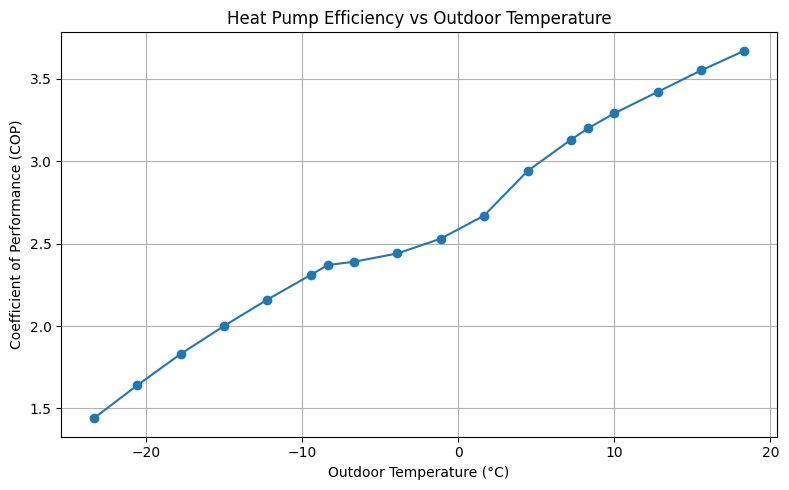

In [3]:
plot_cop_vs_outdoor_temp(heat_pump_df)

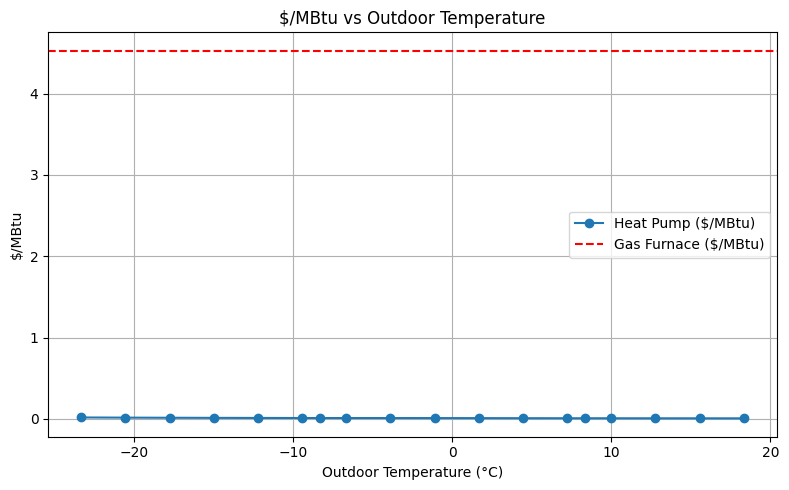

In [4]:
plot_price_comparison(heat_pump_df)

In [5]:
heat_pump_df['HeatPumpPricePerMBtu'] / heat_pump_df['FurnacePricePerMBtu']

0     0.001550
1     0.001604
2     0.001665
3     0.001729
4     0.001780
5     0.001816
6     0.001934
7     0.002128
8     0.002245
9     0.002332
10    0.002377
11    0.002398
12    0.002462
13    0.002640
14    0.002844
15    0.003120
16    0.003480
17    0.003936
dtype: float64

In [6]:
si_df = load_heat_pump_data_si(heat_pump_data_file)
si_df

,LowPressurePSI,HighPressurePSI,CoefficientOfPerformance,CurrentAmps,PowerInputkW,TemperatureRiseF,HeatOutputMBH,OutdoorAirTempF,OutdoorAirTempC,HeatOutputkW,HeatPumpPricePerHour,HeatPumpGJPerHour,HeatPumpPricePerGJ,FurnacePricePerGJ
0,131,372,3.67,11.1,2.93,32,36.7,65,18.333333,10.755708,0.257547,0.038721,6.651429,4.776275
1,123,360,3.55,10.8,2.85,31,34.5,60,15.555556,10.110952,0.250515,0.036399,6.882389,4.776275
2,115,348,3.42,10.4,2.77,29,32.3,55,12.777778,9.466196,0.243483,0.034078,7.144810,4.776275
3,106,336,3.29,10.1,2.69,27,30.2,50,10.000000,8.850746,0.236451,0.031863,7.420937,4.776275
4,102,328,3.20,9.9,2.64,26,28.8,47,8.333333,8.440447,0.232056,0.030386,7.637036,4.776275
5,98,324,3.13,9.7,2.60,26,27.8,45,7.222222,8.147376,0.228540,0.029331,7.791875,4.776275
6,90,312,2.94,9.4,2.52,23,25.3,40,4.444444,7.414698,0.221508,0.026693,8.298382,4.776275
7,74,320,2.67,11.3,2.97,25,27.1,35,1.666667,7.942226,0.261063,0.028592,9.130627,4.776275
8,67,307,2.53,11.0,2.89,23,25.0,30,-1.111111,7.326777,0.254031,0.026376,9.630997,4.776275
9,60,294,2.44,10.6,2.81,21,23.4,25,-3.888889,6.857863,0.246999,0.024688,10.004696,4.776275


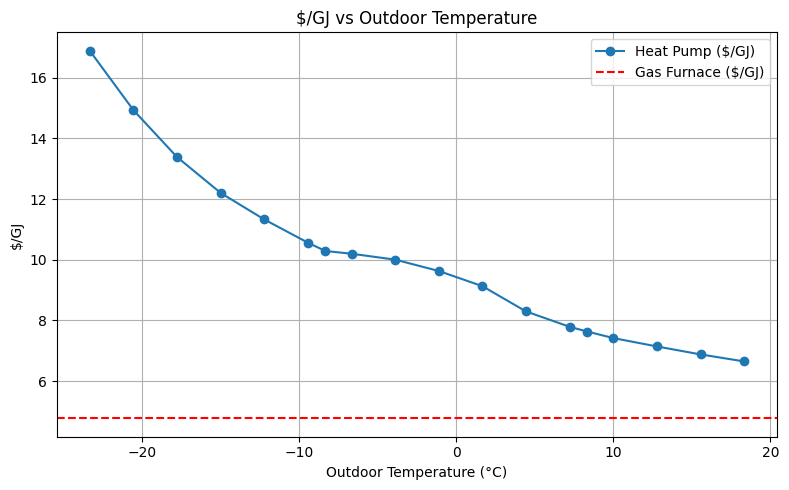

In [7]:
plot_price_comparison(si_df)

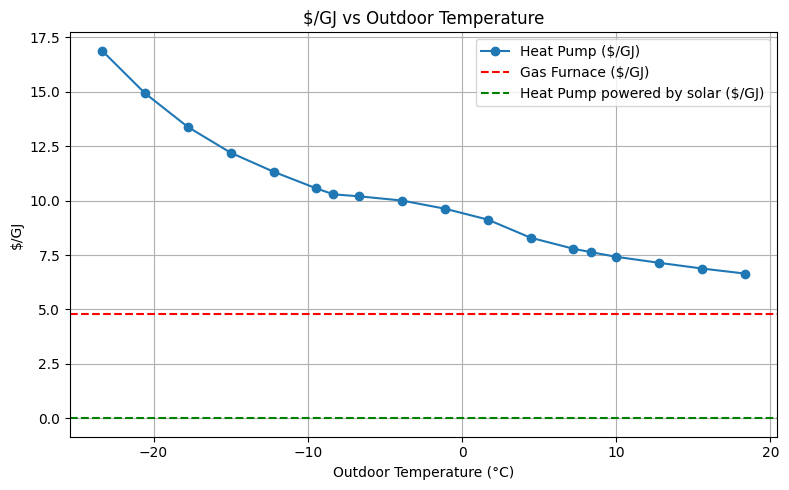

In [8]:

def plot_price_comparison(df):
    """
    Plots Heat Pump vs Furnace cost per MBtu against outdoor temperature in °C.

    Args:
        df (pd.DataFrame): DataFrame with 'OutdoorAirTempC', 'HeatPumpPricePerMBtu', and 'FurnacePricePerMBtu'.
    """
    plt.figure(figsize=(8, 5))
    # Check for HeatPumpPricePerMBtu column
    is_in_mbtu = "HeatPumpPricePerMBtu" in df.columns
    if is_in_mbtu:
        heat_pump_price = df["HeatPumpPricePerMBtu"]
        furnace_price = df["FurnacePricePerMBtu"]
        units = "$/MBtu"
    else:
        heat_pump_price = df["HeatPumpPricePerGJ"]
        furnace_price = df["FurnacePricePerGJ"]
        units = "$/GJ"
    plt.plot(df["OutdoorAirTempC"], heat_pump_price, marker='o', linestyle='-', label=f"Heat Pump ({units})")
    plt.axhline(y=furnace_price.iloc[0], color='red', linestyle='--', label=f"Gas Furnace ({units})")
    plt.axhline(y=0, color='green', linestyle='--', label=f"Heat Pump powered by solar ({units})")

    plt.title(f"{units} vs Outdoor Temperature")
    plt.xlabel("Outdoor Temperature (°C)")
    plt.ylabel(units)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_price_comparison(si_df)